# Implementation of Kinetic Component Analysis

In [1]:
import datetime as dt
import pandas as pd

from strategies.kca import KCA
from utils.analysis_methods import plot_entry_and_exit, calculate_pnl

### Abstract

In this paper, Marcos López de Prado and Riccardo Rebonato introduce the idea of Kinetic Component Analysis (KCA), a state-space application that extracts a signal from a series of noisy measurements by applying a Kalman Filter on a Taylor expansion of a stochastic process (e.g. price signals). In the paper, the authors demonstrate that KCA possesses several advantages over other popular noise reduction methods (e.g. Fast Fourier Transform) - namely, that it can decompose price signals into three hidden components which can be intuitively associated with position, velocity, and acceleration.

### Introduction

For my submission of the Hudson & Thames skillset challenge, I’ve created a trading strategy that utilizes the authors’ implementation of the KCA algorithm and leverages its estimates of kinematic quantities to generate trading rules based on the following cases:

**1)**  <u> Velocity (-), Acceleration (-): </u> 

- If both velocity and acceleration have negative signs we infer this to be a price signal that is on its way down and progressively getting faster
- This suggests that we should ***enter a short*** position (i.e. ***sell***)

**2)**  <u> Velocity (-), Acceleration (+): </u> 

- If velocity has a negative sign and acceleration has a positive we infer this to be a price signal that is on its way down but progressively getting slower
- This suggests that we should ***exit a short*** position (i.e. ***sell***)

**3)**  <u> Velocity (+), Acceleration (+): </u> 

- If both velocity and acceleration have positive signs we infer this to be a price signal that is on its way up and progressively getting faster
- This suggests that we should ***enter a long*** position (i.e. ***buy***)

**4)**  <u> Velocity (+), Acceleration (-): </u> 

- If velocity has a positve sign and acceleration has a negative we infer this to be a price signal that is on its way up but progressively getting slower
- This suggests that we should ***exit a long*** position (i.e. ***sell***)

Crucially, the user has to specify a `lookback_period`, which determines how many days in a row one of these cases has to have been observed in order for us to issue a trading signal

### Data

5 years worth of futures data was queried using the yfinance package for the following 14 futures:

| yfinance Symbol | Description | Start | End |
| :-: | :-: | :-: | :-: |
| ES=F | S&P 500 E-mini | 2007-01-03 | 2012-07-03
| YM=F | Dow Jones E-mini | 2007-01-03 | 2012-07-03 
| NQ=F | Nasdaq 100 | 2007-01-03 | 2012-07-03 
| FTSE | FTSE 100 | 2007-01-03 | 2012-07-03 
| ZB=F | T-Bond 30 yr | 2007-01-03 | 2012-07-03 
| ZN=F | T-Bond 10 yr | 2007-01-03 | 2012-07-03 
| ZF=F | T-Bond 5 yr | 2007-01-03 | 2012-07-03 
| ZT=F | T-Bond 2 yr | 2007-01-03 | 2012-07-03 
| GE=F | Eurodollar | 2007-01-03 | 2012-07-03 
| GC=F | Gold | 2007-01-03 | 2012-07-03 
| CL=F | Crude Oil | 2007-01-03 | 2012-07-03 
| NG=F | Natural Gas | 2007-01-03 | 2012-07-03 
| ZC=F | Corn | 2007-01-03 | 2012-07-03 
| HE=F | Lean Hogs | 2007-01-03 | 2012-07-03 

In [2]:
universe = pd.read_parquet('data/futures.parquet')
universe.head()

,S&P 500 E-mini,Dow Jones E-mini,Nasdaq 100,FTSE 100,T-Bond 30 yr,T-Bond 10 yr,T-Bond 5 yr,T-Bond 2 yr,Eurodollar,Gold,Crude Oil,Natural Gas,Corn,Lean Hogs
Date,,,,,,,,,,,,,,
2007-01-03,1424.75,12530.0,1779.00,6319.000000,111.93750,107.7500,105.250000,102.117188,94.644997,627.099976,58.320000,6.163,370.50,59.500000
2007-01-04,1427.50,12549.0,1812.25,6287.000000,112.40625,108.0625,105.453125,102.203125,94.644997,623.900024,55.590000,6.162,362.25,60.299999
2007-01-05,1416.50,12450.0,1797.25,6220.100098,112.15625,107.8750,105.296875,102.132812,94.642502,604.900024,56.310001,6.184,368.25,60.400002
2007-01-08,1422.50,12492.0,1803.50,6194.200195,112.12500,107.8125,105.234375,102.078125,94.642502,607.500000,56.090000,6.378,363.50,60.299999
2007-01-09,1420.50,12483.0,1810.50,6196.100098,112.12500,107.8125,105.234375,102.054688,94.642502,613.099976,55.639999,6.631,354.50,59.750000


### Step 1: Instantiating and working with the KCA class

The KCA class is an easy to use strategy class that takes 3 required parameters and an optional forecast horizon:

In [3]:
seed = 0.001 # Seed value used by Marcos López de Prado and Riccardo Rebonato
lookback_period = dt.timedelta(days=5)

# Instantiating the class
kca = KCA(
    universe=universe,
    seed=seed,
    lookback_period=lookback_period
)

The class calculates our desired kinematic quantities upon instantiation and stores them in a `kinematics` attribute

In [4]:
kca.kinematics.head()

S&P 500 E-mini                          Dow Jones E-mini               \
        position    velocity acceleration         position     velocity   
0     985.501771  133.807943   -19.508982      8610.555578  1196.391328   
1    1109.466357  114.300697   -19.366801      9718.102334  1020.377409   
2    1213.965979   94.935102   -18.688801     10650.139749   845.880209   
3    1299.410500   76.248611   -17.483050     11410.605798   677.749389   
4    1366.748384   58.769777   -15.829647     12008.291984   520.740970   

                 Nasdaq 100                              FTSE 100  ...  \
  acceleration     position    velocity acceleration     position  ...   
0  -176.050845  1233.953095  182.472159   -26.898508  4329.384963  ...   
1  -174.531053  1402.861745  155.576018   -26.804647  4861.059458  ...   
2  -168.172660  1544.877690  128.772867   -25.970965  5307.787288  ...   
3  -157.063174  1660.463820  102.804754   -24.403731  5671.671348  ...   
4  -141.944253  1750.829460   78.406222   -22.205493  5957.150735  ...   

     Crude Oil Natural Gas                               Corn             \
  acceleration    position  velocity acceleration    position   velocity   
0    -0.142264    6.095813  0.122344    -0.014142  252.354284  34.586661   
1    -0.142964    6.206318  0.112688    -0.014428  284.808355  30.365965   
2    -0.136751    6.310640  0.103972    -0.016929  313.049741  26.173946   
3    -0.121525    6.415012  0.083356    -0.020508  337.153322  22.103320   
4    -0.097517    6.499685  0.046999    -0.020493  357.286506  18.242994   

                Lean Hogs                         
  acceleration   position  velocity acceleration  
0    -4.218969  55.016793  1.500913    -0.199350  
1    -4.189988  56.420212  1.299739    -0.199712  
2    -4.069251  57.620176  1.096783    -0.193738  
3    -3.860009  58.618423  0.899729    -0.179832  
4    -3.580209  59.425366  0.717321    -0.158850  

[5 rows x 42 columns]

To generate our desired trading signal, we make a call to `generate_all_signals_and_positions()`

In [5]:
kca.generate_all_signals_and_positions()

This stores information on how we are positioned relative to each futures contract (e.g. we have an open position in Gold as of 2007-01-04) and each trading signal issued (e.g. buy S&P 500 E-mini on 2008-03-24) at every timestep in attributes called `positions` and `signals`

A value of `1` means currently have an open position and a value of `0` means we currently do not have an open position

In [6]:
kca.positions

,S&P 500 E-mini,Dow Jones E-mini,Nasdaq 100,FTSE 100,T-Bond 30 yr,T-Bond 10 yr,T-Bond 5 yr,T-Bond 2 yr,Eurodollar,Gold,Crude Oil,Natural Gas,Corn,Lean Hogs
Date,,,,,,,,,,,,,,
2007-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2012-07-26,1,1,1,0,1,1,1,1,1,1,1,1,1,1
2012-07-27,1,1,1,0,1,1,1,1,1,1,1,1,1,1


A value of `1` means we should buy the futures contract, a value of `0` means we should do nothing (i.e. the signal has not been triggered yet or we currently have an open position and should not change anything), and a value of `-1` means we should sell the futures contract

In [7]:
kca.signals

,S&P 500 E-mini,Dow Jones E-mini,Nasdaq 100,FTSE 100,T-Bond 30 yr,T-Bond 10 yr,T-Bond 5 yr,T-Bond 2 yr,Eurodollar,Gold,Crude Oil,Natural Gas,Corn,Lean Hogs
Date,,,,,,,,,,,,,,
2007-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-01-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0,0,1,0,0,0,-1,0,0,0,0,0,0,0
2012-07-26,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2012-07-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Step 2: Generating results based on different lookback periods

Using a lookback period of 5 days, lets see the PNL we would generate if we invested 100 dollars in each of our futures

In [8]:
pnls = []
for security in kca.securities:
    pnls.append(calculate_pnl(
        cash=100,
        signals=kca.signals[security],
        prices=kca.universe[security]

    ))
pnls = pd.DataFrame(data=pnls, index=kca.securities, columns=['PNL'])
pnls

,PNL
S&P 500 E-mini,2128.928168
Dow Jones E-mini,1761.619359
Nasdaq 100,3479.914622
FTSE 100,2121.780696
T-Bond 30 yr,351.547181
T-Bond 10 yr,156.415330
T-Bond 5 yr,62.564801
T-Bond 2 yr,5.065944
Eurodollar,2.256724
Gold,2200.812388


In [9]:
print(f'PNL TOTAL SUM: {sum(pnls.values)[0]}')

PNL TOTAL SUM: 66140.5192884103


We can also visualize some of the trading signals in action

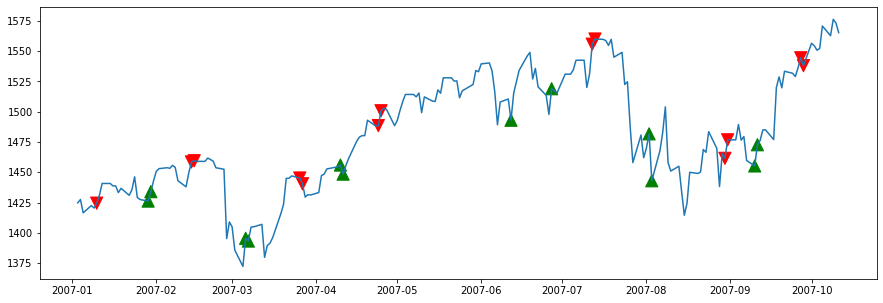

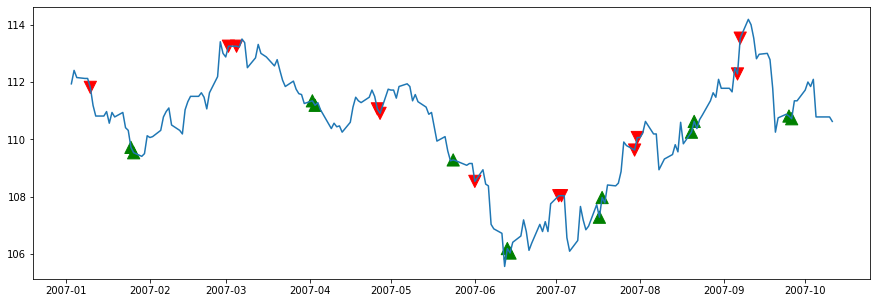

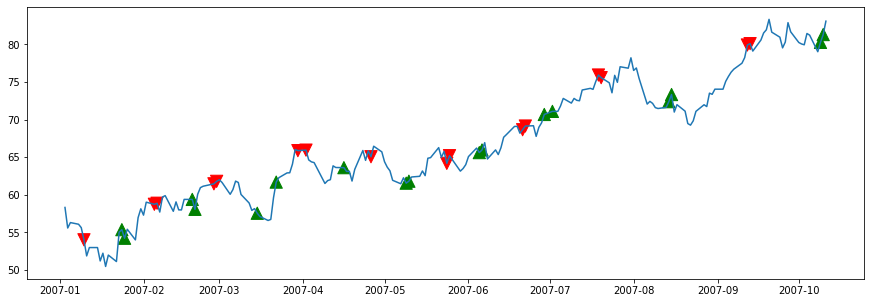

In [10]:
for security in ['S&P 500 E-mini', 'T-Bond 30 yr', 'Crude Oil']:
    plot_entry_and_exit(
        universe=universe,
        signals=kca.signals,
        security=security,
        days=200,
    )

We can repeat this process with a lookback period of 10 days

In [11]:
seed = 0.001 # Seed value used by Marcos López de Prado and Riccardo Rebonato
lookback_period = dt.timedelta(days=10)

# Instantiating the class
kca = KCA(
    universe=universe,
    seed=seed,
    lookback_period=lookback_period
)
kca.generate_all_signals_and_positions()

In [12]:
kca.generate_all_signals_and_positions()

In [13]:
pnls = []
for security in kca.securities:
    pnls.append(calculate_pnl(
        cash=100,
        signals=kca.signals[security],
        prices=kca.universe[security]

    ))
pnls = pd.DataFrame(data=pnls, index=kca.securities, columns=['PNL'])
pnls

,PNL
S&P 500 E-mini,66.140540
Dow Jones E-mini,44.759578
Nasdaq 100,57.448299
FTSE 100,109.666383
T-Bond 30 yr,63.602570
T-Bond 10 yr,-4.411917
T-Bond 5 yr,-1.277725
T-Bond 2 yr,6.264796
Eurodollar,-0.448967
Gold,539.889316


In [14]:
print(f'PNL TOTAL SUM: {sum(pnls.values)[0]}')

PNL TOTAL SUM: 1859.6585312303637


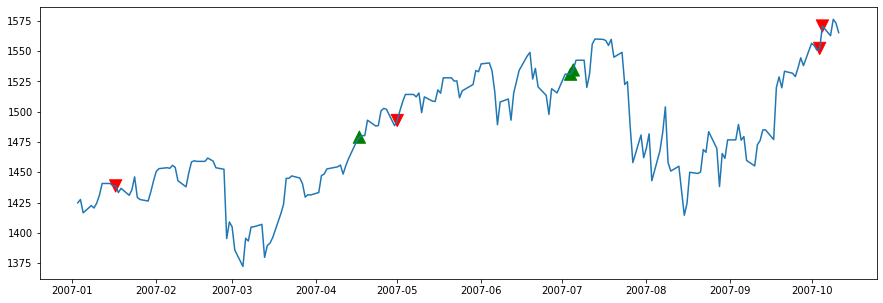

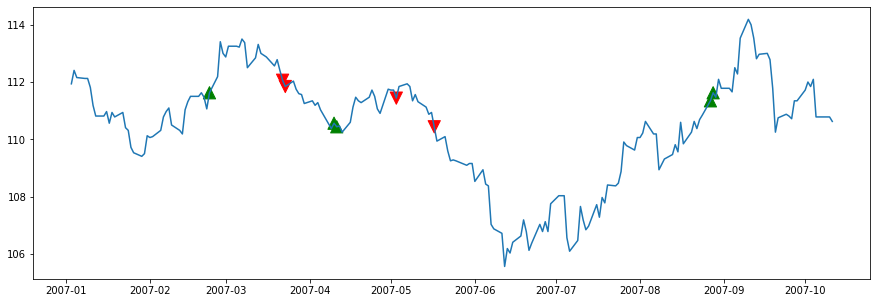

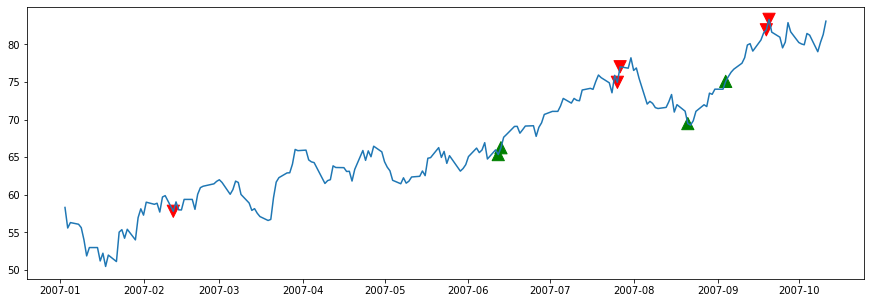

In [15]:
for security in ['S&P 500 E-mini', 'T-Bond 30 yr', 'Crude Oil']:
    plot_entry_and_exit(
        universe=universe,
        signals=kca.signals,
        security=security,
        days=200,
    )

And then finally with 3 days

In [20]:
seed = 0.001 # Seed value used by Marcos López de Prado and Riccardo Rebonato
lookback_period = dt.timedelta(days=3)

# Instantiating the class
kca = KCA(
    universe=universe,
    seed=seed,
    lookback_period=lookback_period
)
kca.generate_all_signals_and_positions()

In [21]:
pnls = []
for security in kca.securities:
    pnls.append(calculate_pnl(
        cash=100,
        signals=kca.signals[security],
        prices=kca.universe[security]

    ))
pnls = pd.DataFrame(data=pnls, index=kca.securities, columns=['PNL'])
pnls

,PNL
S&P 500 E-mini,1335.044478
Dow Jones E-mini,1083.777796
Nasdaq 100,1299.332545
FTSE 100,1413.619999
T-Bond 30 yr,449.452737
T-Bond 10 yr,259.821791
T-Bond 5 yr,145.208397
T-Bond 2 yr,33.711364
Eurodollar,10.442921
Gold,1626.222909


In [22]:
print(f'PNL TOTAL SUM: {sum(pnls.values)[0]}')

PNL TOTAL SUM: 546169.2671233363


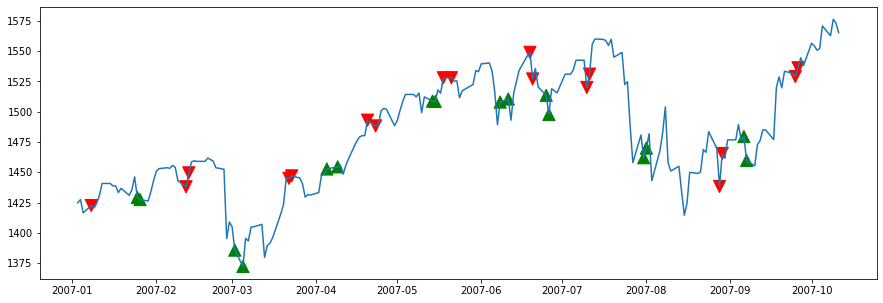

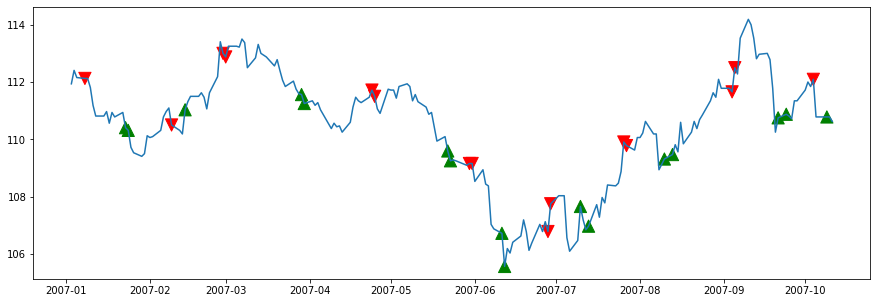

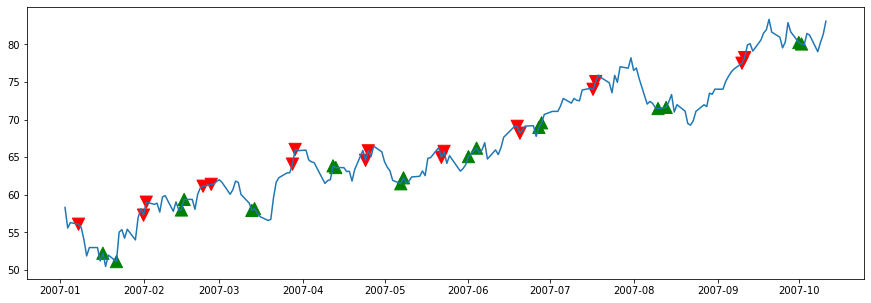

In [23]:
for security in ['S&P 500 E-mini', 'T-Bond 30 yr', 'Crude Oil']:
    plot_entry_and_exit(
        universe=universe,
        signals=kca.signals,
        security=security,
        days=200,
    )

### Step 3: Conclusions